<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/main/cifar_10_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

# 1 Data set

Load the dataset

In [82]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

Inspect the dataset

In [83]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0


In [84]:
print(train_labels[:20])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]
 [9]
 [3]
 [2]
 [6]]


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


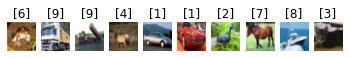

In [85]:
fig, ax = plt.subplots(1,10)
for i in range(10):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

In [86]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_images = train_dataset_images.map(lambda img : tf.cast(img, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# get the value out of the array: [x] -> x
train_dataset_targets = train_dataset_targets.map(lambda t: tf.reshape(t, []))
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))

# center around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

# zip together input and labels
train_dataset_centered = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset_centered = train_dataset_centered.shuffle(buffer_size = 64)
train_dataset_centered = train_dataset_centered.batch(64)
train_dataset_centered = train_dataset_centered.prefetch(tf.data.experimental.AUTOTUNE)

# Same for test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t: tf.reshape(t, []))
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_centered = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
test_dataset_centered = test_dataset_centered.shuffle(buffer_size = 64)
test_dataset_centered = test_dataset_centered.batch(64)
test_dataset_centered = test_dataset_centered.prefetch(tf.data.experimental.AUTOTUNE)

# 2 Model

In [87]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import tensorflow.keras as keras

class Model(Model):
    def __init__(self):
        super(Model, self).__init__()
        # first convolutional block
        self.conv_1 = keras.layers.Conv2D(
            filters = 32,
            kernel_size = 3,
            activation = "relu",
            input_shape = (32, 32, 3)
        )
        # second convolutional block
        self.conv_2 = keras.layers.Conv2D(
            64, (3,3), activation = "relu"
        )
        self.max_pool = keras.layers.MaxPooling2D((2,2))
        # third convolutional layer
        self.conv_3 = keras.layers.Conv2D(
            128, (3,3), activation = "relu",
            kernel_regularizer = tf.keras.regularizers.l2(0.01)
        )
        # forth convolutional block
        self.conv_4 = keras.layers.Conv2D(
            128, (3,3), activation = "relu"
        )

        # classifier head
        self.flatten = keras.layers.Flatten()
        self.output_1 = keras.layers.Dense(units = 32, activation = "relu")
        self.output_2 = keras.layers.Dense(units = 10, activation = "softmax")

    def call(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.max_pool(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.flatten(x)
        x = self.output_1(x)
        x = self.output_2(x)
        return x

# 3 Training

In [88]:
def acc_metric(target,output):
    # how many items in pred and target are same (first cast output from float tensor to int --> rounding)
    acc = np.argmax(target, axis=1) == np.argmax(output, axis=1)
    acc = np.mean(acc)    
    return acc

def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)    
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  acc_metric(target, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 5
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch), end = " ")

    train_dataset_centered = train_dataset_centered.shuffle(buffer_size=64)
    test_dataset_centered = test_dataset_centered.shuffle(buffer_size=64)

    #training (and checking in with training)
    average = []
    length_ds = len(train_dataset_centered)
    for i,(input,target) in enumerate(train_dataset_centered):
        if i % 32 == 0: print("|", end = "")
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        average.append(train_loss)
        
    train_losses.append(np.mean(average))
    
    #testing
    test_loss, test_accuracy = test(model, test_dataset_centered, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(' Test Accuracy: ', test_accuracy)


Epoch: 0 ||||||||||||||||||||||||| Test Accuracy:  0.5846934713375797
Epoch: 1 ||||||||||||||||||||||||| Test Accuracy:  0.6614251592356688
Epoch: 2 ||||||||||||||||||||||||| Test Accuracy:  0.6811305732484076
Epoch: 3 |||||

# 4 Visualization

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(test_accuracies[-1]))
plt.show()